# Mixture Models

In [1]:
from functools import partial
from pprint import pprint
from typing import Callable

import altair as alt
import numpy as np
import pandas as pd
from code_ramblings.models import CountMixtureModel, NegativeBinomialDistribution, PoissonDistribution

# Altair stuff
alt.data_transformers.enable("vegafusion")
alt.renderers.enable("svg")
title: Callable[[str], alt.Title] = partial(alt.Title, color="darkslategrey", fontSize=25)
subtitle: Callable[[str], alt.Title] = partial(alt.Title, color="darkgrey", fontSize=16)

# Data
SEED = 0
N = 10000

rng = np.random.default_rng(SEED)

poisson = rng.poisson(4, N)
nb = rng.negative_binomial(1, 0.5, N)
nb_poisson = np.concatenate([poisson, nb])

distributions = {
    "Poisson": poisson,
    "Negative Binomial": nb,
    "Mixture": nb_poisson,
}

source = pd.concat([pd.DataFrame(data, columns=["values"]).assign(distribution=dist) for dist, data in distributions.items()])

## The "scare" real life data

Data science courses often show you a perfect world. They give you clean data that fits simple patterns. But in the real world? Data is a mess. It's often a mix of different patterns, like our data here, which is a blend of Poisson and Negative Binomial distributions. This notebook is about showing you what real data actually looks like and how to handle it.

The main point isn't just to show you a mixture pattern. It's to reveal that the tidy examples in textbooks don't reflect reality. You learn basic models, but what happens when your data doesn't fit? This "scare" dataset is your rude awakening. Try plotting a simple boxplot on this mixture data, and you'll see it tells you almost nothing useful. It shows how real distributions are often more complicated, needing more than just a simple, off-the-shelf statistical tool.

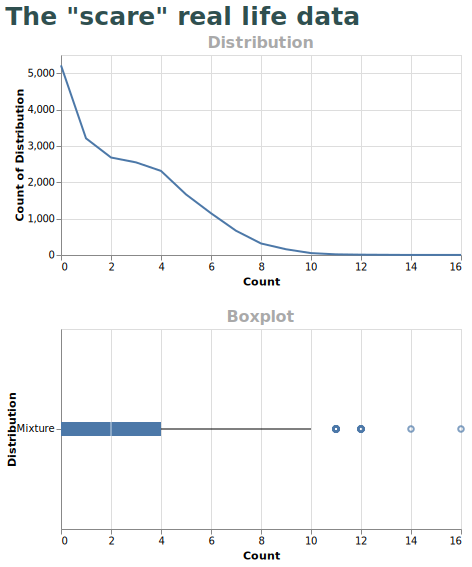

In [2]:
base = (
    alt.Chart(source)
    .transform_filter(alt.datum.distribution == "Mixture")
    .encode(x=alt.X("values:Q", title="Count"))
    .properties(width=400, height=200)
)

line = base.mark_line().encode(y=alt.Y("count()", title="Count of Distribution")).properties(title=subtitle("Distribution"))
boxplot = base.mark_boxplot().encode(y=alt.Y("distribution", title="Distribution")).properties(title=subtitle("Boxplot"))

alt.vconcat(line, boxplot).properties(title=title('The "scare" real life data'))

## The original "scare" real life data against proper statistics

Okay, get ready. We're about to look closely at our "mixed" data. You'll see right away that it's not a simple, common shape. That's the real "scare", in which the raw truth that data rarely matches your easy assumptions.

Next, we'll pull apart this complex data, splitting it into its individual Poisson and Negative Binomial pieces. This isn't just an exercise; it's a key lesson in seeing how complicated overall patterns can come from simpler, hidden parts. It's about getting to the root of the problem instead of just guessing.

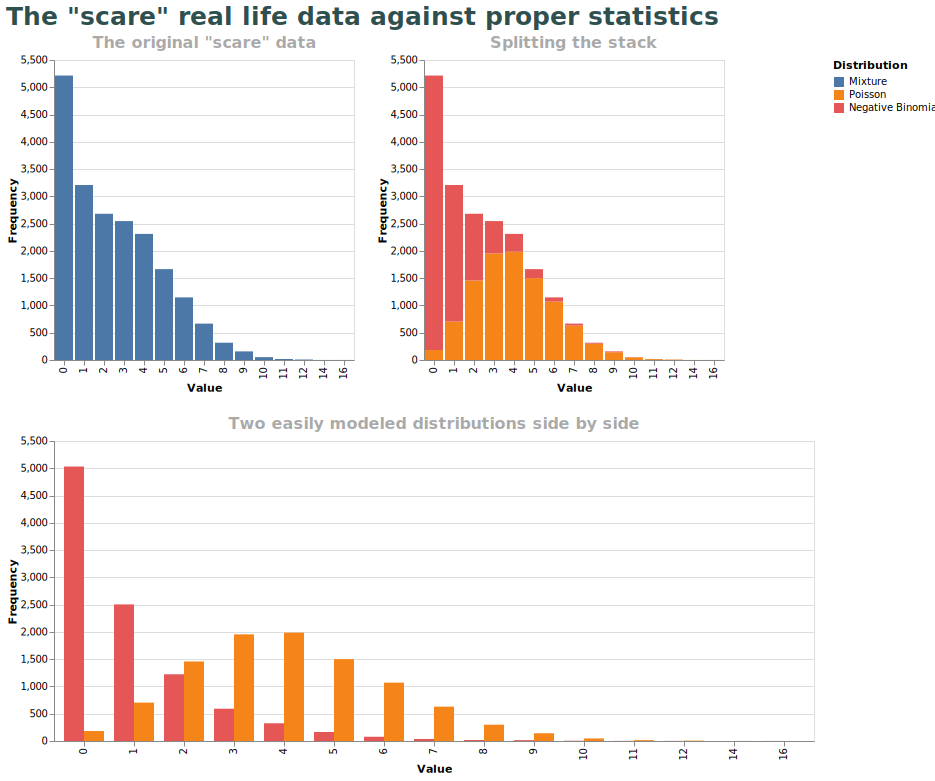

In [3]:
base = (
    alt.Chart(source)
    .mark_bar()
    .encode(
        x=alt.X("values:O", title="Value"),
        y=alt.Y("count()", title="Frequency"),
        color=alt.Color("distribution:N", title="Distribution", sort=["Mixture", "Poisson"]),
    )
)

mixture = base.transform_filter(alt.datum.distribution == "Mixture").properties(title=subtitle('The original "scare" data'))
split = base.transform_filter(alt.datum.distribution != "Mixture").properties(title=subtitle("Splitting the stack"))
offset = split.encode(xOffset=alt.XOffset("distribution:N")).properties(title=subtitle("Two easily modeled distributions side by side"))

alt.vconcat(alt.hconcat(mixture, split), offset).properties(title=title('The "scare" real life data against proper statistics'))

## "But how do I handle it?"

Here we test the best way to handle this kind of data: a mixture model.

Our Poisson-Negative Binomial mixture will show how to manage this combined data, proving that even tough data can be understood and modeled.

Of course, it is very easy to just tell you "use a Poisson-Negative Binomial mixture model for this data", since we simulated the data for this exercise.

However, the main issue here is to be able to master this techniques, and then think about how to implement it to real data. Once the skill is acquired, you'll be able to test and review the assumptions against the domain knowledge to come up with useful insights and further refine your own domain knowledge in a way that adds value.

Mixture Model(
    PoissonDistribution(lambda_=4.020087292894858),
    NegativeBinomialDistribution(r=0.9953835353319658, p=0.5061943128601756)
)

Sample: [0 3 4 4 2 2 1 1 1 5]


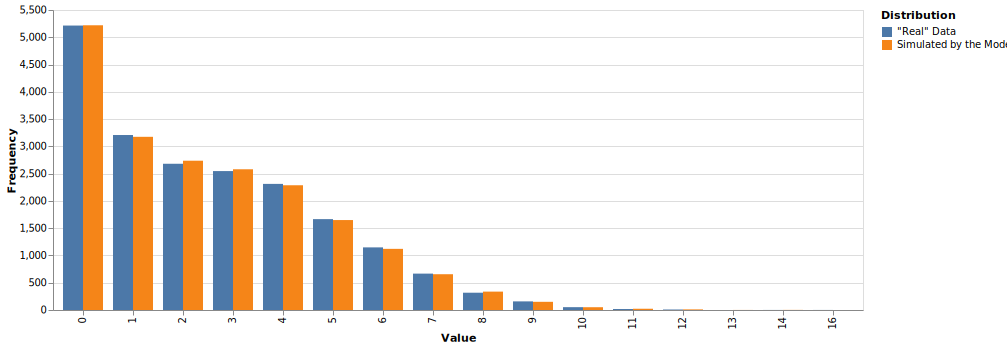

In [4]:
poisson = PoissonDistribution()
nb = NegativeBinomialDistribution()

mixture_model = CountMixtureModel(poisson, nb)
mixture_model.fit(nb_poisson)


distributions = {
    '"Real" Data': nb_poisson,
    "Simulated by the Model": mixture_model.sample(N * 2, seed=0),
}


source = pd.concat([pd.DataFrame(data, columns=["values"]).assign(distribution=dist) for dist, data in distributions.items()])


comparison = (
    alt.Chart(source)
    .mark_bar()
    .encode(
        x=alt.X("values:O", title="Value"),
        y=alt.Y("count():Q", title="Frequency"),
        color=alt.Color("distribution:N", title="Distribution"),
        xOffset=alt.XOffset("distribution:N"),
    )
)

display(mixture_model)
print(f"Sample: {mixture_model.sample(10, seed=0)}")
display(comparison)

## Final Thoughts

As demonstrated in the plot above, the model is able to approximate very well to the parameters we used to generate the data.

You can test many parameters to explore the limits of the accuracy of the model as an exercise and also build your own models to test different distributions. The main point here is to demonstrate the potential and give you a jumpstart on the topic.